In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geopandas as gpd
from shapely.geometry import Point
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from ipywidgets import interact

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data

I copied this from http://dph.illinois.gov/COVID19/STATISTICS, but soon I'll make a scraper to automatically pull new data when this notebook is run.

In [4]:
ZIP_SHAPEFILE_PATH = os.path.join('zip://', 'shapefiles', 'tl_2018_us_county.zip')
county_gdf = gpd.read_file(ZIP_SHAPEFILE_PATH)
cook_county_gdf = county_gdf.loc[county_gdf['GEOID'] == '17031'].copy()
cook_county_gdf.reset_index(drop=True, inplace=True)
cook_county_gdf.crs = 'EPSG:4326'
cook_county_gdf

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,031,01784766,17031,Cook,Cook County,06,H1,G4020,176,16980,16974,A,2447370818,1786313044,+41.8942937,-087.6454546,"POLYGON ((-88.23819 42.06698, -88.23819 42.067..."


In [5]:
ZIP_CODE_SHAPEFILE_PATH = os.path.join('zip://', 'shapefiles', 'tl_2010_17_zcta510.zip')
il_zip_code_gdf = gpd.read_file(ZIP_CODE_SHAPEFILE_PATH)
il_zip_code_gdf['INTPTLAT10'] = il_zip_code_gdf['INTPTLAT10'].astype(float)
il_zip_code_gdf['INTPTLON10'] = il_zip_code_gdf['INTPTLON10'].astype(float)
il_zip_code_gdf.crs = 'EPSG:4326'

cook_county_area_zip_gdf = il_zip_code_gdf.loc[(il_zip_code_gdf['INTPTLAT10'] <= 42.1700) & (il_zip_code_gdf['INTPTLON10'] >= -88.2600) & 
                                               (il_zip_code_gdf['INTPTLAT10'] >= 41.4700) & (il_zip_code_gdf['INTPTLON10'] <= -87.5200)].copy()
cook_county_area_zip_gdf.reset_index(drop=True, inplace=True)
cook_zip_gdf = gpd.overlay(cook_county_area_zip_gdf, cook_county_gdf, how='intersection')

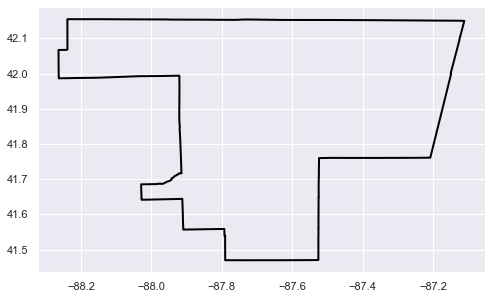

In [6]:
figsize=(8,8)
fig, ax = plt.subplots(figsize=figsize)
base = cook_county_gdf.plot(figsize=figsize, color='none', edgecolor='black', linewidth=2, ax=ax)

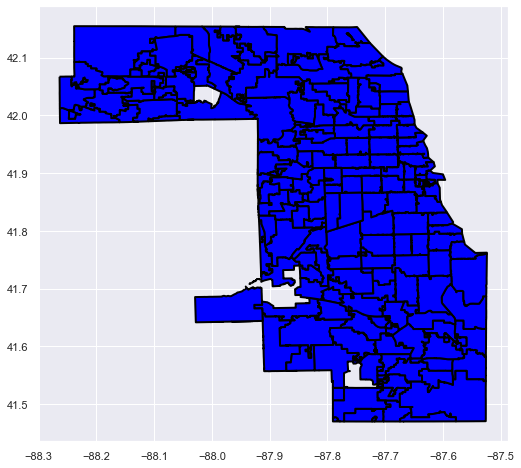

In [7]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
base = cook_zip_gdf.plot(figsize=figsize, color='blue', edgecolor='black', linewidth=2, ax=ax)

In [8]:
ZIP_SHP_PATH = os.path.join('zip://', 'shapefiles', 'Boundaries - City.zip')
chicago_boundary = gpd.read_file(ZIP_SHP_PATH)
chicago_boundary.crs = 'EPSG:4326'
chicago_zip_gdf = gpd.overlay(cook_county_area_zip_gdf, chicago_boundary, how='intersection')

In [9]:
chicago_zip_gdf.head(2)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,name,objectid,shape_area,shape_len,geometry
0,17,60453,1760453,B5,G6350,S,21904195,59,41.713437,-87.752560,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.72036 41.69196, -87.72034 ..."
1,17,60068,1760068,B5,G6350,S,18373706,77742,42.011762,-87.843434,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.81633 42.01875, -87.81633 ..."


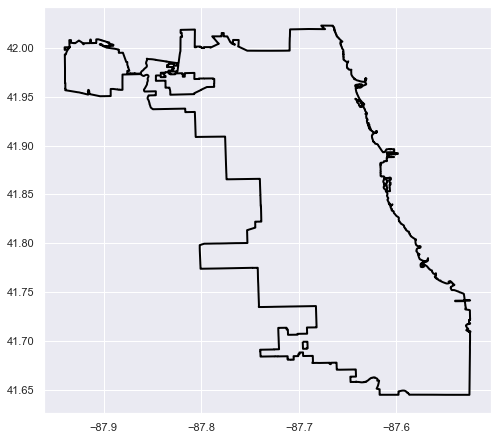

In [10]:
figsize=(8,8)
fig, ax = plt.subplots(figsize=figsize)
base = chicago_boundary.plot(figsize=figsize, color='none', edgecolor='black', linewidth=2, ax=ax)

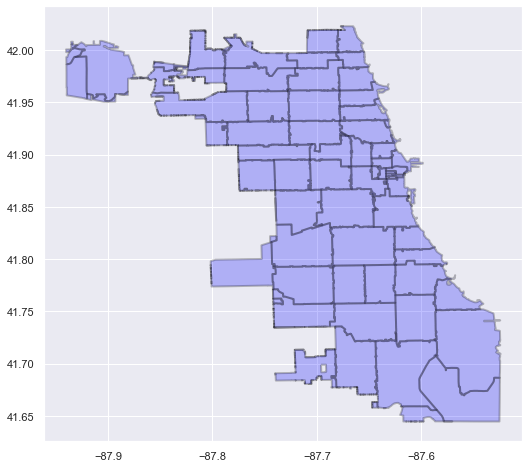

In [11]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
base = chicago_zip_gdf.plot(figsize=figsize, color='blue', edgecolor='black', linewidth=2, alpha=0.25, ax=ax)

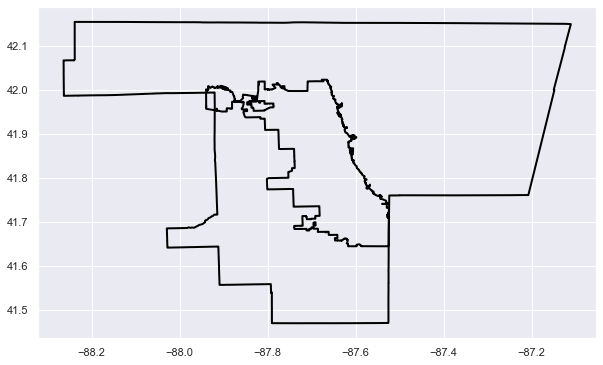

In [12]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
base = chicago_boundary.plot(figsize=figsize, color='none', edgecolor='black', linewidth=2, ax=ax)
ax = cook_county_gdf.plot(color='none', edgecolor='black', linewidth=2, ax=base)

In [13]:
CSV_PATH = os.path.join('data_raw', 'dph_illinois_by_zip_2020_04_07.csv')
covid_by_zip_df = pd.read_csv(CSV_PATH, dtype={'County':'object'})
covid_by_zip_df.rename({'County':'zip_code'}, axis=1, inplace=True)
covid_by_zip_cook_gdf = pd.merge(left=cook_zip_gdf, right=covid_by_zip_df, how='left', left_on='ZCTA5CE10', right_on='zip_code')
covid_by_zip_chicago_gdf = pd.merge(left=chicago_zip_gdf, right=covid_by_zip_df, how='left', left_on='ZCTA5CE10', right_on='zip_code')
covid_by_zip_cook_gdf['Positive Cases'] = covid_by_zip_cook_gdf['Positive Cases'].fillna(0)
covid_by_zip_chicago_gdf['Positive Cases'] = covid_by_zip_chicago_gdf['Positive Cases'].fillna(0)

In [14]:
covid_by_zip_chicago_gdf.head(2)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,name,objectid,shape_area,shape_len,geometry,zip_code,Positive Cases,Deaths
0,17,60453,1760453,B5,G6350,S,21904195,59,41.713437,-87.752560,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.72036 41.69196, -87.72034 ...",60453,80.0,NaN
1,17,60068,1760068,B5,G6350,S,18373706,77742,42.011762,-87.843434,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.81633 42.01875, -87.81633 ...",60068,57.0,NaN


In [15]:
CSV_PATH = os.path.join('data_raw', 'dph_illinois_by_zip_2020_04_07.csv')
covid_by_zip_df = pd.read_csv(CSV_PATH, dtype={'County':'object'})
covid_by_zip_df.rename({'County':'zip_code'}, axis=1, inplace=True)
covid_by_zip_gdf = pd.merge(left=cook_zip_gdf, right=covid_by_zip_df, how='left', left_on='ZCTA5CE10', right_on='zip_code')
covid_by_zip_gdf['Positive Cases'] = covid_by_zip_gdf['Positive Cases'].fillna(0)

In [22]:
def map_covid19_cases_by_location(gdf, location, figsize=(15,15), scale=0.6, 
                                  alpha=0.6, cmap='YlGn', col='Positive Cases'):
    fig, ax = plt.subplots(figsize=figsize)
    ax = gdf.plot(column=col, figsize=figsize,  cmap=cmap, edgecolor='black', linewidth=2, ax=ax)
    ax.set_title(f'Confirmed COVID-19 Cases in {location} by Zip Code on 2020-04-07', fontsize=20)
    ax = ax.axis('off')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=covid_by_zip_gdf[col].max()))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale, alpha=alpha)
    cbar.set_label('COVID-19 Cases by Zip Code', size=20)
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()

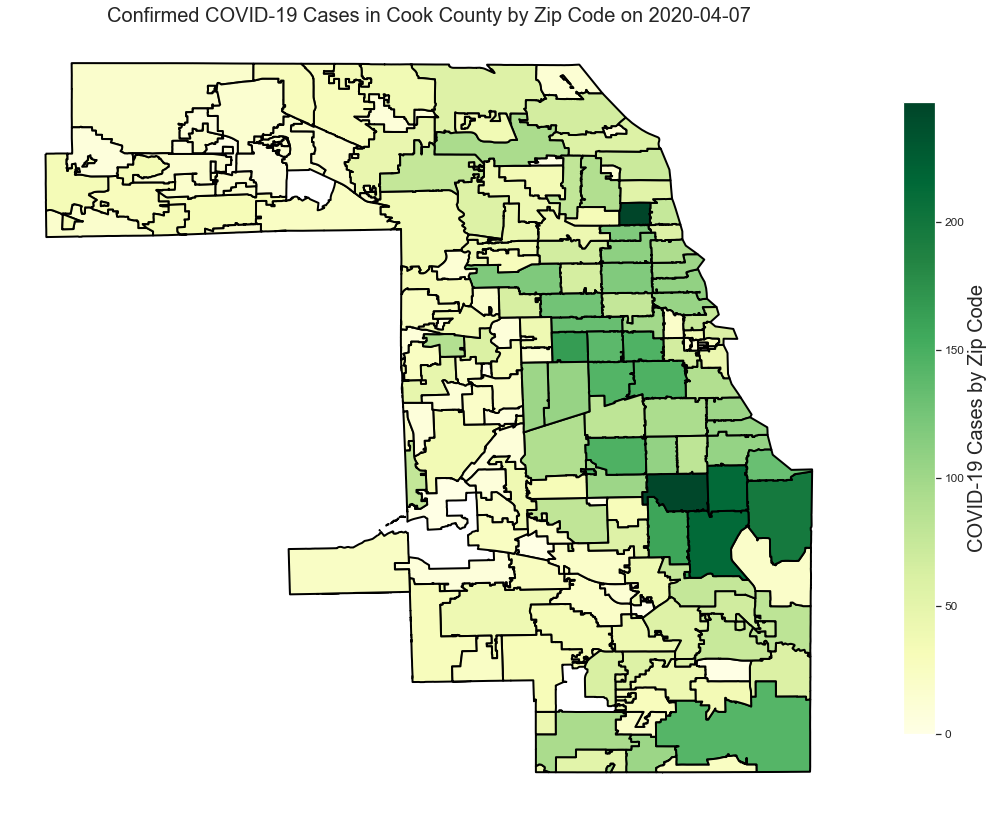

In [23]:
map_covid19_cases_by_location(gdf=covid_by_zip_gdf, location="Cook County", figsize=(15,15), scale=0.6, 
                                  alpha=1, cmap='YlGn', col='Positive Cases')

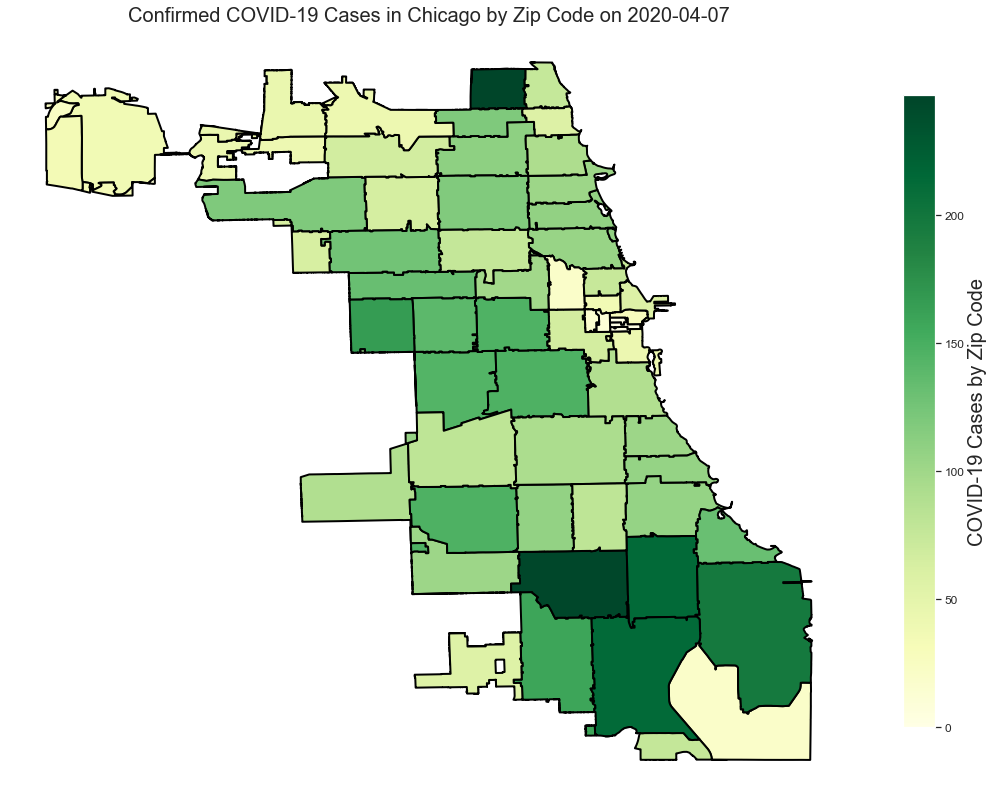

In [24]:
map_covid19_cases_by_location(gdf=covid_by_zip_chicago_gdf, location="Chicago", figsize=(15,15), scale=0.6, 
                                  alpha=1, cmap='YlGn', col='Positive Cases')